In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
from qiskit.algorithms.optimizers import SPSA

from problem_formulation import Node, Line , Grid , UCProblem
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, assemble
import json
import os

In [2]:
def power_expansion(n, expression, power):
    
    """
    Runs fortran code to take in polynomial expression of binary variables and returns
    an expression for that polynomial to some power n, and reads the output through a terminal.

    n (int): The number of variables
    expression (array/list of floats): Coefficients of all possible terms such that the m-th element is
                                  the coefficient of (x_1^m_1)(x_2^m_2)...(x_n^m_n) where the binary
                                  expansion of m is m_n...m_2m_1.
    power (int): Power to exponentiate the expression to.

    Returns: An expression in the same format of the input raised to the given power
    """

    #print("\tPower expansion")
    #print("\tPower: ", power)

  # Call fortran program via command line to do the computation
    inputLine = './taylor_precomp_fortran' +' ' +str(n) + ' '+ ' '.join([str(float(el)) for el in expression])+ ' ' + str(int(power))
    data = os.popen(inputLine).read().split()
    
    #print("Data read:", data)
    output_expression=[float(el) for el in data]
    #print("Output expression", output_expression)
    return np.array(output_expression)



In [3]:
def get_cos_expression(n, no_terms):
    """
    Use Taylor expansion of cos(2pi*x) to get a polynomial expression of x expressed in terms
    of its binary digits encoded such that the maximum value x can take (x_i=1 for all i) is
    (2^n - 1)/2^n.

    n (int): Number of bits of x.
    no_terms (int): Number of terms of the Taylor expansion to be used.

    Returns: Polynomial expression for cos(2pi*x) encoded as a list such that the m-th element
             is the coefficient of (x_1^m_1)(x_2^m_2)...(x_n^m_n) where the binary
             expansion of m is m_n...m_2m_1.
    """
    
    print("Get cos(x) expression")

    # Express the binary expansion of x in the same way we express the output 
    # polynomaial as lists of coefficients

    x_expansion=np.array([0.0 for _ in range(2**n)])

    # x = (2*pi/2^n)\sum 2^i x_i  -  pi

    x_expansion[0]=-np.pi

    for i in range(n):
        x_expansion[2**i]=2**i*(2*np.pi)/2**n

    # cos_expansion: Taylor expansion of cos where the coefficient of x^i is stored in the i-th element 
    cos_expansion=[((-1)**(1+i/2)/np.math.factorial(i) if i%2==0 else 0) for i in range(2*no_terms-1)]

    # cos_expression: Final polynomial expression approximating cos(x) where we store the coefficients
    # of every possible term of binary variables
    cos_expression=np.array([0.0 for _ in range(2**n)])

    # Calculate expression of x^2 in terms of binary variables first since cos is an even function
    x_2=power_expansion(n,x_expansion,2)

    # Calculate polynomial expression for each term in cos_expansion and keep adding to
    # cos expression
    for i in range(len(cos_expansion)):
        if cos_expansion[i]!=0:
            cos_expression+=cos_expansion[i]*(power_expansion(n, x_2, i/2))
    return cos_expression

In [4]:

node1=Node([20,20], 1, 1, 1, "gen1")
node2=Node([60,60], 1, 1, 1, "gen2")
node3=Node([-80,-80], 0,0,0, "load1")
line1=Line(node1,node2,80,80)
line2=Line(node1,node3,80,80)
line3=Line(node2,node3,20,20)
lines = [line1,line2,line3]
nodes = [node1,node2,node3]
nodes.sort(reverse=True, key=lambda node:node.real_power[0])
        

In [5]:

grid_timesteps = Grid(lines, nodes, [True for _ in nodes])

B=grid_timesteps.A
C, max_eigval=grid_timesteps.A_eig_bounds


In [6]:
qadc_qubit_count = 2
n = qadc_qubit_count
no_terms = 4
#k = 
t = 0
i = 1
j = 0
C_L = 80
real_powers = [node.real_power for node in nodes]
min_eigval = C
params_temp=ParameterVector('p_temp', 2)

k = abs(B[i][j])*C_L*(np.linalg.norm(np.array([r[t] for r in real_powers]))/min_eigval)*params_temp[0]
k

ParameterExpression(43411.1494937404*p_temp[0])

In [7]:
#def construct_exp_k_abs_cos_circuit(n, no_terms, k):
"""
Create a QuantumCircuit that, given |x>, pulls out a phase exp(ik|cos(x)|)

n (int): Number of bits of x.
no_terms (int): Number of terms of the Taylor expansion to be used.
k (float|int): Constant k in expression exp(ik|cos(x)|)

Returns: QuantumCircuit
"""
qc=QuantumCircuit(n)

print("Constructing exp(ik|cos(x)|)")

# Check if angles have already been computed and stored in json file. If so, use them.

with open('cos_angles.json') as f:
    data = json.load(f)

if str(n)+"_"+str(no_terms) in data.keys():
    cos_expression=data[str(n)+"_"+str(no_terms)]["angles"]
else:
    cos_expression=get_cos_expression(n, no_terms)

    with open('cos_angles.json', 'w', encoding='utf-8') as f:
        data[str(n)+"_"+str(no_terms)+"_"+str(k)]={"angles": list(cos_expression)}
        json.dump(data, f, ensure_ascii=False, indent=4)

Constructing exp(ik|cos(x)|)
Get cos(x) expression


In [8]:
cos_expression

array([ 1.21135284, -1.21045832, -2.21135284,  2.21135284])

In [13]:
terms_dealt

[1, 1, 1, 1]

In [11]:


# Each term in the expression we get is a phase that is to be added, controlled on certain
# qubits. The order in which we apply these phases doesn't matter. We might as well pick an
# order that minimizes depth and packs all the operations as tightly as possible.

# This list keeps track of which terms in the expression have already been dealt with on the circuit
terms_dealt=[0 for _ in cos_expression]

# While there are terms that haven't been worked into the circuit, keep running this loop.
# Each iteration deals with one layer of depth and picks the terms from the expression that maximizes
# the number of qubits used while making sure none of the terms overlap.
# This is a greedy algorithm to minimize the depth.
while 0 in terms_dealt:
    # i is the index of the term that is being looked at. We initialize it to 0
    i=0
    # Keep track of the terms that make up the current layer 
    current_terms=[]
    while i < len(cos_expression):
        # If the i-th term has already been dealt with, increment i by 1 and continue
        if terms_dealt[i]==1:
            i+=1
            continue
        # If the i-th coefficient is 0, no operation is necessary. Increment i by 1 and continue. 
        if cos_expression[i]==0:
            terms_dealt[i]=1
            i+=1
            continue

        # If we're still in the loop at this point, we have a non trivial term in the expression.
        # Define the variable 'term' as a list with 0-th element being the phase angle and 1st element
        # being a list of qubit indices that should control the phase for this term
        term=[cos_expression[i], [n-1-m for m in range(n) if (format(i, 'b').zfill(n))[m]=='1']]

        # This if condition checks to make sure there is no repetition in qubits used if you added
        # the qubits from term to the qubits of all the terms in current_terms
        if len([el for c_term in current_terms for el in c_term[1]]+term[1])==len(list(set([el for c_term in current_terms for el in c_term[1]]+term[1]))):
            # If there is no repetition, then add term to current_terms, set terms_dealt to 1
            # to indicate that the i-th term is dealt with now.
            terms_dealt[i]=1
            current_terms+=[term]

            # We will add a phase indicated by term[0] and controlled on the qubits
            # specified in term[1]
            angle=term[0]
            bits=term[1]

            # Replacing the last qubit with the second last one changes the polynomial expression
            # for cos(x) to that of |cos(x)|
            if n-1 in bits:
                bits.remove(n-1)
                if n-2 not in bits:
                    bits+=[n-2]

            # Apply the gate to add the phase
            if len(bits)==1:
                qc.p(k*angle, bits[0])
            elif len(bits)==2:
                qc.cp(k*angle, bits[0], bits[1])
            elif len(bits)>2:
                qc.mcp(k*angle, [bit for bit in bits[1:]], bits[0])

        i+=1

#return qc


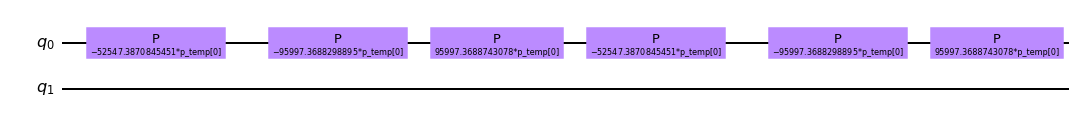

In [12]:
qc.draw("mpl")